# License
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at:

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Instructions
This Notebook contain the code use to produce plots displayed in the paper.

To generate a particular plot:


1.   Execute the "Imports & Utils" section.
2.   Execute cells containing "Library" functions for the subsection generating the desired plot.
3.   Execute the "Load data" cell of the experiment needed by the subsection.
4.   Execute the "Run" cell of the subsection that should output the plot.

For reference, example outputs are displayed in each subsection.



# Imports & Utils

In [ ]:
import json
import matplotlib
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import tensorflow as tf
from collections import defaultdict
from functools import partial
from matplotlib import pyplot as plt

# Graph drawing imports
import imageio
import pydot
from IPython.core.display import display, HTML, Image
from IPython.display import clear_output
from graphviz import Digraph, Graph

In [ ]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [ ]:
def df_write_to_file(df, dir_path, df_name):
  filename_df = os.path.join(dir_path, f'{df_name}.csv')
  with tf.io.gfile.GFile(filename_df, 'w') as outfile:
    df.to_csv(outfile, index=False)

def df_read_from_file(dir_path, df_name,):
  filename_df = os.path.join(dir_path, f'{df_name}.csv')
  with tf.io.gfile.GFile(filename_df, 'r') as infile:
    df = pd.read_csv(infile)
  # Pandas read_csv() reads empty stings as NaNs. Set NaNs to empty strings in
  # columns with type strings/object.
  for c in df.columns:
    if df[c].dtype == np.object_:
        df[c].fillna('', inplace=True)
  return df

In [ ]:
NOT_TRAINABLE = 'NOT_TRAINABLE'  # Refers to the root model.
def get_total_params(df):
  return df['final_accounted_params'].sum()
def get_task_names(df):
  return df.query(f'task_name!="NOT_TRAINABLE"')['task_name'].to_list()
def get_num_task(df):
  return len(set(df.query(f'task_name!="NOT_TRAINABLE"')['task_name'].to_list()))
def get_params_per_task(df):
  return get_total_params(df) / get_num_task(df)
def get_test_quality(df):
  return df['metrics.test_quality'].mean()
def get_validation_quality(df):
  return df['metrics.quality'].mean()
def get_time_per_gen(df):
  return (df['metrics.end_time'].mean() - df['metrics.start_time_loop'].mean())
def get_tpu_hours(df):
  return sum(df.query('task_name!="NOT_TRAINABLE"')['metrics.train_time'].to_list()) / 3600

In [ ]:
class ExpData():
  def __init__(self, path, comps=False):
    self.path = path
    self.dfp = df_read_from_file(path, 'population')
    self.dfh = df_read_from_file(path, 'paths')
    if comps:
      self.dfc = df_read_from_file(path, 'components')

In [ ]:
def get_exps_data(pattern):
  return [ExpData(exp_dir) for exp_dir in tf.io.gfile.glob(pattern)]
def get_dirs(pattern):
  return tf.io.gfile.glob(pattern)

In [ ]:
def levenshtein(a, b):
    'Calculates the Levenshtein distance between a and b.'
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n
    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)
    return current[n]

def intersection_size(a, b):
  return len(set(a) & set(b))

In [ ]:
def get_best_ids(df, step, filter_not_trainable=True):
  """Return ids of best paths for each task at a given step."""
  best_ids = []
  df = df.query(f'id<={step}').sort_values('id', ascending = True)
  task_names = [tn for tn in df['task_name'].unique()]
  for tn in task_names:
    if tn.startswith(NOT_TRAINABLE):
      if filter_not_trainable:
        continue
      id = df.query(f'task_name=="{tn}"').id.to_list()
      assert len(id) == 1
      best_ids.append(id[0])
    else:
      dft = df.query(f'task_name=="{tn}" and `metrics.new_best`==True')
      best_ids.append(dft.loc[dft['id'].idxmax()]['id'])
  return best_ids

In [ ]:
def read_exp_config(exp_dir):
  try:  # OLD FORMAT
    load_config_dict_file = exp_dir + '/config.json'
    return json.load(
        tf.io.gfile.GFile(load_config_dict_file, 'r'))
  except:  # NEW STATE FOLDER FORMAT
    load_config_dict_file = exp_dir + '/../config.json'
    return json.load(
        tf.io.gfile.GFile(load_config_dict_file, 'r'))

In [ ]:
def get_task_color(task_name, colormap='turbo', hex=False, split_private=True):
  # Ref: https://matplotlib.org/stable/tutorials/colors/colormaps.html
  # Example color maps: gist_rainbow rainbow hsv jet turbo brg prism
  cmap = matplotlib.cm.get_cmap(colormap)
  if task_name not in task_names_colors:
    return None
  ratio = task_names_colors.index(task_name)/(len(task_names_colors)-1)
  if colormap == 'turbo':
    # Cap range to avoid darker colors.
    rmin = 0.16
    rmax = 0.84
    ratio = ratio * (rmax-rmin) + rmin
  color = cmap(ratio)
  if split_private and task_name.startswith('private:'):
    color = tuple(min(v+0.4, 1.) for v in color)
  if hex:
    color = matplotlib.colors.rgb2hex(color)
  return color

# Single experiment analysis

## Load data

In [ ]:
# Directory containing the state csv files of an experiment.
EXPERIMENT_DIR = '' # @param { 'type' : 'string' }

dfp = df_read_from_file(EXPERIMENT_DIR, 'population')
dfh = df_read_from_file(EXPERIMENT_DIR, 'paths')
dfc = df_read_from_file(EXPERIMENT_DIR, 'components')

exp_config = read_exp_config(EXPERIMENT_DIR)

final_models_ids = dfp.query(f'task_name!="{NOT_TRAINABLE}"')['id'].tolist()
max_id=max(dfh['id'].tolist())

task_names = dfp.query(f'task_name!="{NOT_TRAINABLE}"')['task_name'].unique()
task_names_colors = [tn for tn in dfp['task_name'].unique() if tn != NOT_TRAINABLE]

## Leaderboard

In [ ]:
#@title Run
dfp.query(f'task_name!="NOT_TRAINABLE"')[[
    'task_name',
    'metrics.quality',  # Validation accuracy
    'metrics.test_quality',  # Test accuracy
    ]]

,task_name,metrics.quality,metrics.test_quality
1,emnist/digits,0.970898,0.97135
2,emnist/letters,0.907595,0.88750
3,kmnist,0.911000,0.82050
4,mnist,0.967000,0.96810
5,omniglot,0.615894,0.60641
6,cmaterdb/bangla,0.868000,0.85500
7,cmaterdb/devanagari,0.888000,0.82400
8,cmaterdb/telugu,0.904000,0.86200


## Stats summary

In [ ]:
#@title Run
num_devices = 8

print(exp_config['experiment_id'])
v = dfp['score'].mean()
print(f'Average score: {100*v:.4f}')
v = dfp['metrics.quality'].mean()
print(f'Average quality: {100*v:.4f}')
if 'metrics.test_quality' in dfp:
  v = dfp['metrics.test_quality'].mean()
  print(f'Average test quality: {100*v:.4f}')

v = dfp['final_accounted_params'].sum()
print(f'Total num params: {v:.0f}')
v = dfp['metrics.num_trainable_params'].sum()
print(f'Total trainable params: {v:.0f}')
v = len(set(dfp.query(f'task_name!="{NOT_TRAINABLE}"')['task_name'].to_list()))
print(f'Total num tasks: {v}')
print(f'Params per task {get_params_per_task(dfp)}')

v = dfh['metrics.loop_time'].mean()
print(f'Average path loop time: {v:.2f} s')
v = dfh['metrics.compile_time'].mean()
print(f'Average path compile time: {v:.2f} s')
v = dfh['metrics.train_time'].mean()
print(f'Average path train time: {v:.2f} s')
v = dfh['metrics.eval_time'].mean()
print(f'Average path eval time: {v:.2f} s')

total_run_time_s = (dfh['metrics.end_time']-dfh['metrics.start_time_loop']).sum() / num_devices
v =  total_run_time_s/60/60
print(f'Total live run time: {v:.2f} h')
v = (dfh['metrics.end_time'].mean() - dfh['metrics.start_time_loop'].mean()) / num_devices
print(f'Average time per path: {v:.2f} s')

if exp_config['load_experiment']:
  print()
  print('Comparison on shared task vs loaded model')
  def compare_exps(exp_a_dir, exp_b_dir):
    dfp_a = df_read_from_file(exp_a_dir, df_name='population')
    dfp_b = df_read_from_file(exp_b_dir, df_name='population')
    shared_tasks = set(dfp_a['task_name'].to_list()).intersection(set(dfp_b['task_name'].to_list()))
    shared_tasks = [task_name for task_name in shared_tasks if not task_name.startswith(NOT_TRAINABLE)]
    dfa = dfp_a.loc[dfp_a['task_name'].isin(shared_tasks)]
    dfb = dfp_b.loc[dfp_b['task_name'].isin(shared_tasks)]
    for k in ['score', 'metrics.quality', 'metrics.test_quality']:
      print(f'Change in {k}: {100*dfa[k].mean():.4f} -> {100*dfb[k].mean():.4f}')
  compare_exps(exp_config['load_experiment_dir'], exp_config['experiment_dir'])

## Graph animation

In [ ]:
# @title Library
STYLE1 = dict(
  colormap = "brg",
  current_task_color = '#FFD700',  # gold
  current_task_penwidth = '5',
  default_penwidth='3',
  fontname="Courier New:bold",
  fontcolor="white",
  capitalize=False,
  node_hight='0.5',
  node_width='0.75',
  node_gray='#444444',
  nodesep="0.25",
  ranksep="0.5",
)
STYLE_PAPER = dict(
  colormap="turbo", # Alternatives: "gist_rainbow" "rainbow" "hsv"
  current_task_color ="black",
  current_task_penwidth = '1.5',
  default_penwidth='1.5',
  fontname="",
  fontcolor="black",
  capitalize=True,
  node_hight='0.',
  node_width='0.',
  node_gray="#aaaaaa",
  nodesep="0.15",
  ranksep="0.1",
)
STYLE = STYLE_PAPER

def render_dot(dot, filename, resolution):
  dot.format = 'png'
  dot.graph_attr['dpi'] = str(resolution)
  local_file = dot.render(filename)
  return local_file

def current_task_attr(attr):
  attr['color'] = STYLE["current_task_color"]
  attr['penwidth'] = STYLE["current_task_penwidth"]
  return attr

def private_task_attr(attr):
  attr['fontcolor'] = 'black'
  return attr

def format_node_name(sstr, with_id=False):
  # Format string to display in node.
  if not with_id:
    sstr = re.sub("_[0-9]*$", "", sstr)
  sstr = re.sub("_", " ", sstr)
  sstr = re.sub("^visual_domain_decathlon/", "VDD ", sstr)
  if not sstr.endswith('/1k'):
    sstr = re.sub("^.*/", "", sstr)

  # These names match the paper description:
  sstr = sstr.replace('encoderblock', 'transformer layer')
  if sstr == 'cls':
    sstr = 'class token'
  sstr = sstr.replace('embedding', 'patch embedding')
  sstr = sstr.replace('posembed input', 'position embedding')
  if STYLE["capitalize"]:
    sstr = sstr.capitalize()
  return sstr

def format_node_id(sstr):
  return re.sub(":", "|", sstr)

def sort_comp_ids(comp_ids, dfc):
  max_num_layers = 24
  recurrent_layers = [[f'residual_adapter_{i}',f'encoderblock_{i}'] for i in range(max_num_layers)]
  recurrent_layers = [v for vs in recurrent_layers for v in vs]
  sorted_layers = ['embedding', 'cls', 'posembed_input'] + recurrent_layers + ['encoder_norm', 'head']

  name2cid = {}
  for cid in comp_ids:
    comp_name = dfc.query(f'id=={cid}').name.unique()
    assert len(comp_name) == 1
    name2cid[comp_name[0]] = cid

  new_comp_ids = []
  for name in sorted_layers:
    if name in name2cid:
      new_comp_ids.append(name2cid.pop(name))

  assert len(name2cid) == 0, f'Cannot sort components: {name2cid.keys()}'
  return new_comp_ids

def filter_component(comp_ids, c_name, dfc):
  new_comp_ids = []
  for cid in comp_ids:
    comp_name = dfc.query(f'id=={cid}').name.unique()
    assert len(comp_name) == 1
    if comp_name[0] != c_name:
      new_comp_ids.append(cid)
  return new_comp_ids

def dot_paths(
    df, p_ids,
    dfc=None,
    step=None,
    highlight_current_task=False,
    filter_adapters=True,
    display_step=False,
    ):
  if highlight_current_task:
    assert step is not None
    current_task = df.query(f'id=={step}').task_name.tolist()[0]
  dot = Graph(
      name='PathNet',
      node_attr={
          'shape': 'Mrecord',
          'style':'filled',
          'fillcolor':STYLE["node_gray"],
          'penwidth':'0',
          'fontname': STYLE["fontname"],
          'fontcolor': STYLE["fontcolor"],
          'height':STYLE["node_hight"],
          'width':STYLE["node_width"],
      },
      graph_attr={
          'rankdir':'BT',
          "outputorder":"edgesfirst",
          "nodesep":STYLE["nodesep"],
          "ranksep":STYLE["ranksep"],
          }
  )

  for p_id in p_ids:
    p_row = df.query(f'id=="{p_id}"')
    assert len(p_row) == 1, p_id
    quality = p_row['metrics.quality'].tolist()[0]
    tn = p_row.task_name.tolist()[0]
    t_color = get_task_color(tn, STYLE["colormap"], hex=True)
    is_current_task = highlight_current_task and current_task == tn

    comp_ids = p_row.components.tolist()
    assert len(comp_ids) == 1
    comp_ids = comp_ids[0]
    comp_ids = comp_ids.split('_')
    # Use this if component names are not sorted.
    comp_ids = sort_comp_ids(comp_ids, dfc)

    # Maybe not meaningful to display last encoder norm layer that is logically
    # part of the head.
    comp_ids = filter_component(comp_ids, 'encoder_norm', dfc)

    prev = format_node_id(tn)
    for cid in comp_ids:
      dot.edge(
          prev,
          cid,
          color= t_color if not is_current_task else STYLE["current_task_color"],
          penwidth=STYLE["default_penwidth"] if not is_current_task else STYLE["current_task_penwidth"],
          # Clip to center of nodes.
          headclip='false',
          tailclip='false',
      )
      # If we have the components dataframe look up info.
      if dfc is not None:
        comp_name = dfc.query(f'id=={cid}').name.unique()
        assert len(comp_name)==1
        label = format_node_name(comp_name[0], with_id=True)
      else:
        label = cid
      # Task name where this component was trained, that is the task of the first path that contains this component.
      ctn = dfh[dfh['components'].str.contains(f'^{cid}_|_{cid}_|_{cid}$', regex=True)].sort_values('id', ascending = True).iloc[0].task_name

      attr = {'fillcolor':get_task_color(ctn, STYLE["colormap"], hex=True)}
      if is_current_task:
        attr = current_task_attr(attr)
      if ctn.startswith('private:'):
        attr = private_task_attr(attr)
      dot.node(cid, label, attr)
      prev = cid

    attr = {'fillcolor':t_color}
    if is_current_task:
      attr = current_task_attr(attr)
    if tn.startswith('private:'):
      attr = private_task_attr(attr)
    quality_str = f'{100*quality:.2f}%' if quality != 1 else '100%'
    dot.node(cid, quality_str, attr)
    dot.node(format_node_id(tn), format_node_name(tn), attr)

  # Add step to image
  if step and display_step:
    attr={
        'shape':'plain',
        'fillcolor':'white',
        'fontsize':'8',
        'fontcolor':"black",
        }
    dot.node('legend', str(step), attr)
  return dot

### Select graph with slider

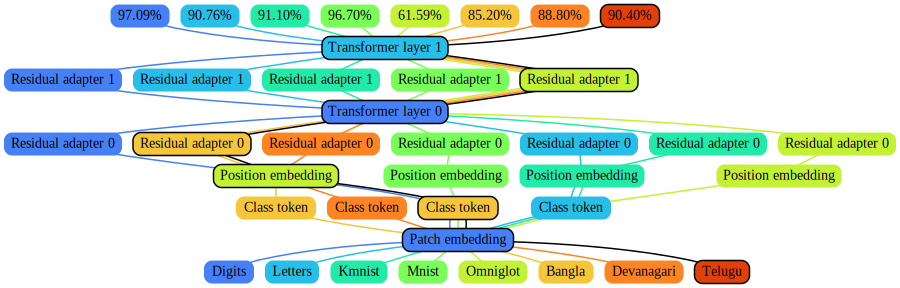

In [ ]:
#@title Run
EXPERIMENT_PROGRESS = 100  #@param {type: "slider", min: 0.0, max: 100.0, step: 0.05}
HIGHLIGHT_CURRENT_TASK = True # @param [True, False] { type: 'boolean', isTemplate: true }
SLIDER_STEP = int(max_id * EXPERIMENT_PROGRESS / 100)
dot_paths(dfh, get_best_ids(dfh, SLIDER_STEP), dfc, SLIDER_STEP, highlight_current_task=HIGHLIGHT_CURRENT_TASK)

### Save image of graph selected with slider

In [ ]:
#@title Run
FILENAME = 'final-state-image'  #@param { 'type' : 'string' }
SAVE_DIR = ''  #@param { 'type' : 'string' }
RESOLUTION_DPI = 80  #@param { 'type' : 'integer' }

dot = dot_paths(dfh, get_best_ids(dfh, SLIDER_STEP), dfc, SLIDER_STEP, highlight_current_task=HIGHLIGHT_CURRENT_TASK)

local_file = render_dot(dot, FILENAME, RESOLUTION_DPI)
output_file = os.path.join(SAVE_DIR, local_file)
tf.io.gfile.copy(local_file, output_file, overwrite=True)
print('Image saved at:', output_file)

### Produce Video

In [ ]:
#@title Run
VIDEO_FILE_NAME = 'evolution-video'  #@param { 'type' : 'string' }
SAVE_DIR = ''  #@param { 'type' : 'string' }
RESOLUTION_DPI = 80  #@param { 'type' : 'integer' }
FRAMES_PER_SECOND = 1  #@param { 'type' : 'integer' }

local_png = 'video-frame'
local_gif = VIDEO_FILE_NAME + '.gif'

files = []
for step in range(0, max_id+1, 8):
  dot = dot_paths(dfh, get_best_ids(dfh, step), dfc, step, highlight_current_task=True)
  local_f = render_dot(dot, f'{local_png}-{step}', RESOLUTION_DPI)
  files.append(local_f)
# Add last frame at max id without current path highlight.
dot = dot_paths(dfh, get_best_ids(dfh, max_id), dfc, max_id, highlight_current_task=False)
local_f = render_dot(dot, f'{local_png}-end', RESOLUTION_DPI)
files.append(local_f)

def get_pad_size(curr, padded):
  assert curr<=padded
  delta = padded - curr
  ld = int(delta / 2)
  rd = delta - ld
  return (ld, rd)

# Find biggest needed framesize and apply aspect ratio.
aspect_ratio = 16/9  # 16:9 youtube aspect ratio.
frame_size = [90, 160]
for local_f in files:
  image = imageio.imread(local_f)
  for i in [0, 1]:
    if image.shape[i] > frame_size[i]:
      frame_size[i] = image.shape[i]
frame_size = [int(max(frame_size[0], frame_size[1]/aspect_ratio)),
              int(max(frame_size[1], frame_size[0]*aspect_ratio))]

with imageio.get_writer(local_gif, mode='I', duration=1/FRAMES_PER_SECOND) as writer:
  for local_f in files:
    image = imageio.imread(local_f)
    pad_width = (get_pad_size(image.shape[0], frame_size[0]),
                 get_pad_size(
                     image.shape[1], frame_size[1]),
                 (0,0))
    image = np.pad(image, pad_width=pad_width, mode='maximum')
    writer.append_data(image)
  # Linger on the last frame.
  for i in range(20):
    writer.append_data(image)

# Save a copy of gif and last frame if output dir is set.
if SAVE_DIR:
  def output_path(filename):
    return os.path.join(SAVE_DIR, filename)
  tf.io.gfile.copy(files[-1], output_path(files[-1]), overwrite=True)
  output_gif = output_path(local_gif)
  tf.io.gfile.copy(local_gif, output_gif, overwrite=True)
  print('Video saved at:', output_gif)

# Display video.
with open(local_gif, 'rb') as f:
  display(Image(data=f.read(), height=600))

## Shared components heatmap

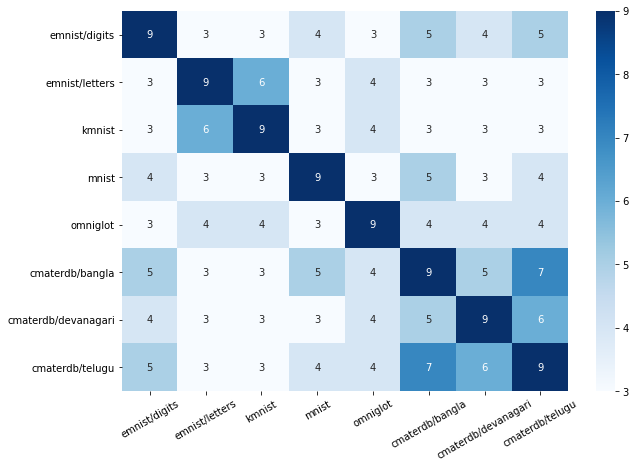

In [ ]:
# @title Run
def format_task_name(tn):
  tn = tn.replace('visual_domain_decathlon/', '')
  return tn

tn2cids = {}
for index, row in dfp.iterrows():
  if row.task_name == NOT_TRAINABLE:
    continue
  tn2cids[format_task_name(row.task_name)] = row.components.split('_')

num_tasks = len(tn2cids)
matrix = np.zeros([num_tasks, num_tasks])
for i, tni in enumerate(tn2cids):
  for j, tnj in enumerate(tn2cids):
    matrix[i, j] = intersection_size(tn2cids[tni], tn2cids[tnj])

def plot_cm(matrix):
  df_cm = pd.DataFrame(
      matrix,
      index = tn2cids.keys(),
      columns = tn2cids.keys())

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  plt.xticks(rotation=30)
  plt.show()
plot_cm(matrix)

## Miscellaneous

In [ ]:
# @title Table
dfp[['id', 'task_name','hparams.num_layers', 'metrics.quality', 'score']]

In [ ]:
# @title Histogram
COLUMN_NAME = 'hparams.num_layers'  #@param  { 'type' : 'string' }
dfh.hist(column=COLUMN_NAME, bins=30)

In [ ]:
#@title Plot library
def custom_plot(df, query=None, xl='id', yl='score', idl='id', plot_type='plot',
         mark_best=False,
         plot_kwargs={}):
  plt.xlabel(xl)
  plt.ylabel(yl)

  if query:
    df = df.query(query)
  df = df.sort_values(xl, ascending = True)
  xs = df[xl].tolist()
  ys = df[yl].tolist()
  if plot_type == 'scatter':
    plt.scatter(xs, ys)
  else:
    plt.plot(xs, ys, **plot_kwargs)
  if idl:
    ids = df[idl].tolist()
    for x, y, id in zip(xs, ys, ids):
      plt.annotate(id, (x, y))
  if mark_best:
    max_id = ys.index(max(ys))
    plt.scatter([xs[max_id]], [ys[max_id]], marker='x', s=100, c='k')
  plt.grid(True)

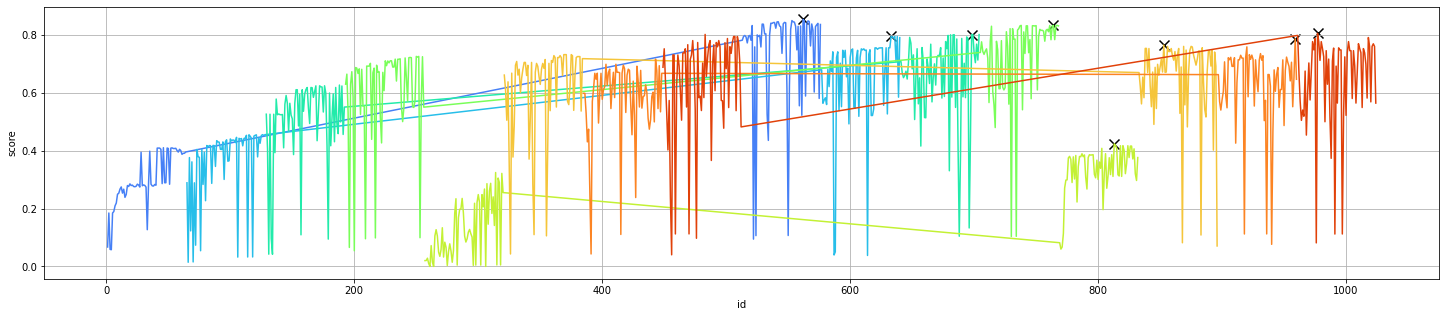

In [ ]:
plt.figure(figsize=(25,5))

for tn in task_names:
  plot_kwargs = {'color' : get_task_color(tn)}
  query=f'task_name=="{tn}"'
  custom_plot(dfh, query, idl=None, mark_best=True, plot_kwargs=plot_kwargs)

In [ ]:
# @title Ancestors plot library
def plot_ancestor(df, path_id, xl='id', yl='score', idl='id',
                  plot_kwargs={}):
  plt.xlabel(xl)
  plt.ylabel(yl)

  xs = []
  ys = []
  ids = []

  def iter(xs, ys, ids, p_id):
    res = df.loc[df['id'] == p_id]
    if len(res) == 0:
      return xs, ys, ids, None
    else:
      assert len(res) == 1
      parent_id = res['parent_id']
      assert len(parent_id) == 1
      parent_id = parent_id.tolist()[0]
      if np.isnan(parent_id):
        return xs, ys, ids, None
      parent_id = int(parent_id)
    xs.append(float(res[xl]))
    ys.append(float(res[yl]))
    if idl:
      ids.append(int(res[idl]))
    return xs, ys, ids, parent_id

  while path_id is not None:
    xs, ys, ids, path_id = iter(xs, ys, ids, path_id)
  plt.plot(xs, ys, **plot_kwargs)
  if idl:
    for x, y, id in zip(xs, ys, ids):
      plt.annotate(id, (x, y))
  plt.grid(True)

In [ ]:
# @title Plot ancestors tree
plt.figure(figsize=(25,5))

y1 = 'generation'
yl = 'score'

for id in range(max_id, 0, -1):
  tn = dfh.query(f'id=={id}').task_name.tolist()
  if len(tn) == 0:
    continue
  tn = tn[0]
  plot_kwargs = { 'color' : get_task_color(tn)}
  plot_ancestor(dfh, id, yl=yl, idl=None, plot_kwargs=plot_kwargs)

# ref:
# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
plot_kwargs = {
    'linestyle': ' ',
    'color': 'k',
    'marker': '+',
    'markersize': 15,
}
for id in final_models_ids:
  plot_ancestor(dfh, id, yl=yl, idl=None, plot_kwargs=plot_kwargs)

In [ ]:
#  @title Plot schedule of selected hyperparameter or metric across the sequence of ancestors for each final model
COLUMN_NAME = 'hparams.opt_lr'  #@param  { 'type' : 'string' }
for id in final_models_ids:
  plot_kwargs = { 'color' : 'k'}
  plot_ancestor(dfh, id, yl=COLUMN_NAME, idl=None, plot_kwargs=plot_kwargs)
  plt.title(f'path id:{id}')
  plt.show()

## Paths analysis

In [ ]:
# @title Print paths ancestors

TASK_NAME = ''  # @param  { 'type' : 'string' }

def print_ancestors(dfp, dfh, target_task_name):
  for index, row in dfp.iterrows():
    pid = row['id']
    # print(pid)
    row = dfh.query(f'id=={pid}')
    # print(row)
    assert len(row) == 1
    task_name = row['task_name'].to_list()[0]
    if task_name == NOT_TRAINABLE:
      continue
    if task_name != target_task_name:
      continue
    ancestor_task_name = task_name
    ancestor_pid = pid
    while ancestor_task_name != NOT_TRAINABLE:
      row = dfh.query(f'id=={ancestor_pid}')
      assert len(row) == 1
      ancestor_pid = row['parent_id'].to_list()[0]
      ancestor_task_name = row['parent_task_name'].to_list()[0]
      print(ancestor_task_name)

print_ancestors(dfp, dfh, TASK_NAME)

In [ ]:
# @title Print component ancestors

TASK_NAME = ''  # @param  { 'type' : 'string' }

def get_cname(cid):
  return dfc.query(f'id=={cid}')['name'].to_list()[0]

def have_same_cname(cid1, cid2):
  return get_cname(cid1) == get_cname(cid2)

def print_ancestors(dfp, dfh, dfc, target_task_name):
  for index, row in dfp.iterrows():
    pid = row['id']
    row = dfh.query(f'id=={pid}')
    assert len(row) == 1
    task_name = row['task_name'].to_list()[0]
    if task_name == NOT_TRAINABLE:
      continue
    if task_name != target_task_name:
      continue
    print(pid, task_name)
    ancestor_task_name = task_name
    ancestor_pid = pid
    cid2ancestor_cid = {}
    cid2ancestor_tasks = {}
    for cid in row['components'].to_list()[0].split('_'):
      cid2ancestor_cid[cid] = cid
      cid2ancestor_tasks[cid] = set()

    while ancestor_task_name != NOT_TRAINABLE:
      row = dfh.query(f'id=={ancestor_pid}')
      assert len(row) == 1
      a_cids = row['components'].to_list()[0].split('_')
      for k_cid, cid in cid2ancestor_cid.items():
        if cid is None:
          continue
        if cid not in a_cids:
          matched = False
          for a_cid in a_cids:
            if have_same_cname(a_cid, cid):
              assert have_same_cname(a_cid, k_cid)
              matched = True
              cid2ancestor_cid[k_cid] = a_cid
              cid2ancestor_tasks[k_cid].add(ancestor_task_name)
          if not matched:
            cid2ancestor_cid[k_cid] = None
            cid2ancestor_tasks[k_cid].add(ancestor_task_name)

      ancestor_pid = row['parent_id'].to_list()[0]
      ancestor_task_name = row['parent_task_name'].to_list()[0]
  print('>>> ', cid2ancestor_tasks)
  for k, v in cid2ancestor_tasks.items():
    print(k, len(v), get_cname(k))

print_ancestors(dfp, dfh, dfc, TASK_NAME)

# Aggregated experiments analysis

## Knowledge flow graph

In [ ]:
# @title Library
def get_tn2atn(ed):
  tn2atn = defaultdict(lambda:defaultdict(lambda:0))
  for index, row in ed.dfp.iterrows():
    pid = row['id']
    row = ed.dfh.query(f'id=={pid}')
    assert len(row) == 1
    task_name = row['task_name'].to_list()[0]
    if task_name == NOT_TRAINABLE:
      continue
    ancestor_task_name = task_name
    ancestor_pid = pid
    while ancestor_task_name != NOT_TRAINABLE:
      row = ed.dfh.query(f'id=={ancestor_pid}')
      assert len(row) == 1
      ancestor_pid = row['parent_id'].to_list()[0]
      ancestor_task_name = row['parent_task_name'].to_list()[0]
      if ancestor_task_name != NOT_TRAINABLE:
        tn2atn[task_name][ancestor_task_name] += 1
  return tn2atn

def format_node_name(node_name):
  node_name = node_name.replace('visual_domain_decathlon/', 'vdd/')
  return node_name

def render_dot(dot, filename='flow', resolution=300):
  dot.format = 'png'
  dot.graph_attr['dpi'] = str(resolution)
  local_f = dot.render(filename)
  return local_f

def plot_tn2atn_dot(tn2atn, save_dir=None):
  dot = Digraph()
  for k in tn2atn:
    for kk in tn2atn[k]:
      denom = sum(tn2atn[k].values())
      bias = 0.5*denom
      w = str((tn2atn[k][kk]+bias)/(denom+bias))
      dot.edge(format_node_name(kk), format_node_name(k), penwidth=w, arrowsize=w)
  display(dot)
  if save_dir:
    local_f = render_dot(dot)
    output_file = save_dir+'/flow.png'
    tf.io.gfile.copy(local_f, output_file, overwrite=True)
    print(output_file)

def get_sum_tn2atns(eds):
  sum_tn2atn = defaultdict(lambda:defaultdict(lambda:0))
  for ed in eds:
    tn2atn = get_tn2atn(ed)
    for k in tn2atn:
      for kk in tn2atn[k]:
        sum_tn2atn[k][kk] += tn2atn[k][kk]
  return sum_tn2atn

def plot_kfg_dot(eds, save_dir=None):
  plot_tn2atn_dot(get_sum_tn2atns(eds_kfg), save_dir)

In [ ]:
# @title Load data
# Can be a regexp for multiple state dir, in the case will aggregate
EXP_DIRS = ''  # @param { 'type' : 'string' }
eds_kfg = get_exps_data(EXP_DIRS)

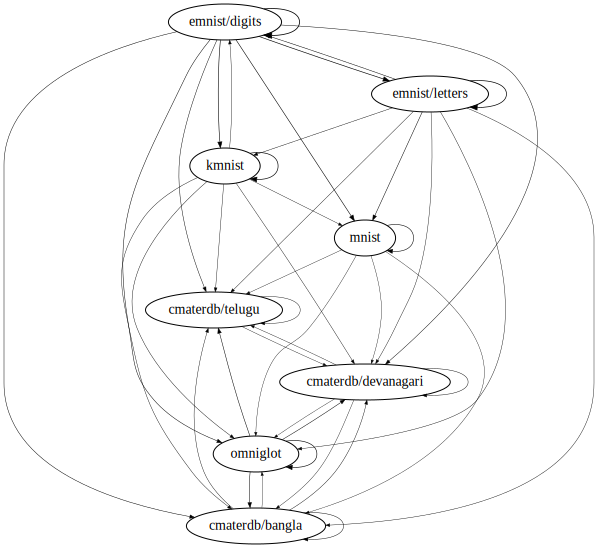

In [ ]:
# @title Run
plot_kfg_dot(eds_kfg, save_dir='')

## Knowledge flow Heatmap

In [ ]:
# @title Library
def heatmap_kfg(tn2atn, normalize=True, percentage=True):
  task_names = [format_node_name(tn) for tn in tn2atn.keys()]
  num_tasks = len(task_names)
  matrix = np.zeros([num_tasks, num_tasks])
  for i, tni in enumerate(tn2atn):
    for j, tnj in enumerate(tn2atn):
      matrix[i, j] = tn2atn[tni][tnj]

  if normalize:
    row_sums = matrix.sum(axis=1)
    matrix = matrix / row_sums[:, np.newaxis]
    if percentage:
      matrix *= 100

  df_cm = pd.DataFrame(
      matrix,
      index = task_names,
      columns = task_names)
  plt.figure(figsize = (15,12))
  ax = plt.axes()
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  # plt.xticks(rotation=30)
  ax.set_title(title_kfh)
  plt.show()

# heatmap_kfg(kfg_counts)

In [ ]:
# @title Load data
# Can be a regexp for multiple state dir, in the case will aggregate
EXP_DIRS = ''  # @param { 'type' : 'string' }
title_kfh='Multitask Character Classification'
eds_kfh = get_exps_data(EXP_DIRS)

In [ ]:
# @title Run
kfh_counts = get_sum_tn2atns(eds_kfh)
heatmap_kfg(kfh_counts)

## Hparams distributions

In [ ]:
# @title Library

def format_lbls(lbls):
  def format_lbl(lbl):
    if lbl == 0.005:
      return '5e-3'
    if lbl == 0.002:
      return '2e-3'
    if lbl == 0.001:
      return '1e-3'
    return lbl
  return [format_lbl(lbl) for lbl in lbls]

def plot_hparams_distributions(
    eds, ncols=5, figsize=(17, 11), save_dir=''):
  plt.rcParams["font.family"] = "STIXGeneral"
  plt.rcParams["font.size"] = 10
  df = pd.DataFrame()
  for ed in eds:
    df = df.append(ed.dfp.query('task_name!="NOT_TRAINABLE"'), ignore_index=True)
    # print(df)
  keys = sorted([k for k in df if k.startswith('hparams.') and \
                 k not in [
                           'hparams.num_classes', 'hparams.adapter_layers',
                           'hparams.adapter_dim', 'hparams.ds_image_size',
                           'hparams.num_layers', 'hparams.opt_lr_schedule'
                           ]])
  nrows = int(np.ceil(len(keys) / ncols))
  fig, ax = plt.subplots(
      nrows=nrows,
      ncols=ncols,
      figsize=figsize)

  for i, row in enumerate(ax):
    for j, ax in enumerate(row):
      k_idx = i * ncols + j
      if k_idx >= len(keys):
        fig.delaxes(ax)
        continue
      k = keys[k_idx]
      vc = df[k].value_counts(normalize=True)
      lbls, vs = zip(*sorted(zip(list(vc.index), vc.to_list()), key=lambda x: x[0]))
      ax.bar(range(len(vs)), vs, tick_label=format_lbls(lbls))
      title = k.split('.')[-1].replace('_', ' ')
      if title.startswith('ds '):
        title = title[3:]
      if title == ' mu ':
        title = 'mutation probability'
      ax.set_title(title)
  plt.subplots_adjust(
       hspace=0.26, wspace=0.15)
  if save_dir:
    plt.savefig('/tmp/hist.pdf', dpi=500, bbox_inches='tight')
    save_file = os.path.join(save_dir, 'hist.pdf')
    tf.io.gfile.copy('/tmp/hist.pdf', save_file, overwrite=True)
    print('Saved to:', save_file)

In [ ]:
# @title Load data
# Can be a regexp for multiple state dir, in the case will aggregate
EXP_DIRS = ''  # @param { 'type' : 'string' }
eds_hd = get_exps_data(EXP_DIRS)

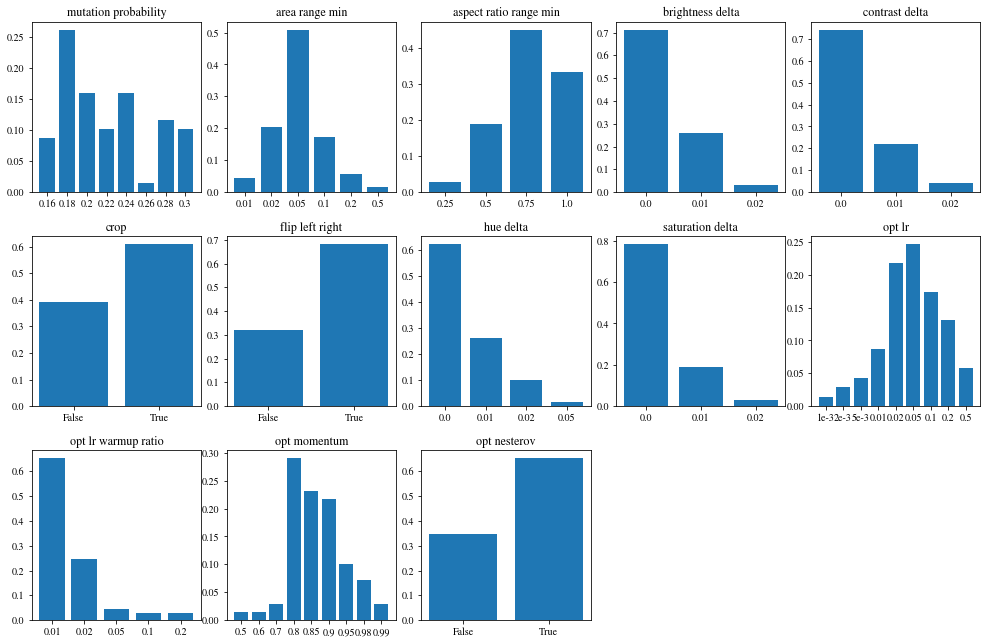

In [ ]:
# @title Run
plot_hparams_distributions(eds_hd)

# Multiple experiments analysis

## Plot quality/size aggregated

In [ ]:
# @title Library
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 35

def get_replicas_data(exp_prefix, num_replicas):
  replicas_data = {}
  for i in range(num_replicas):
    replicas_data[i+1] = get_exps_data(f'{exp_prefix}*replica{i+1}:*')
  return replicas_data

def plot_pqsa(exps_data, fig_size=20,
              colors=None, markers=None,
              x_range=None, y_range=None,
              yaxis_right=False,
              add_legend=True,
              x_exp=None):
  if not colors:
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'] * 20
  if not markers:
    markers = ['s',  '^', 'o',] * 20

  fig1, ax1 = plt.subplots(figsize=(fig_size, fig_size * 0.618))

  get_quality = get_test_quality
  yfn = lambda df: 100*get_quality(df)

  for exp_name in exps_data:
    color = colors.pop(0)
    xsd = {}
    ysd = {}
    num_points = None
    for rid in exps_data[exp_name]:
      xs = []
      ys = []
      for e in exps_data[exp_name][rid]:
        xs.append(get_params_per_task(e.dfp))
        ys.append(yfn(e.dfp))
      xsd[rid], ysd[rid] = xs, ys
      if not num_points:
        num_points = len(xsd[rid])
      assert num_points == len(xsd[rid]) == len(ysd[rid]), \
          f'{exp_name} {rid}'

    xs = []
    ys = []
    ds = []
    xds = []
    for i in range(num_points):
      xs.append(np.mean([vs[i] for vs in xsd.values()]))
      ys.append(np.mean([vs[i] for vs in ysd.values()]))
      ds.append(1*np.std([vs[i] for vs in ysd.values()]))
      xds.append(1*np.std([vs[i] for vs in xsd.values()]))
    xs, ys, ds, xds = zip(*sorted(zip(xs, ys, ds, xds)))

    ax1.plot(xs, ys, label=exp_name, marker=markers.pop(0), color=color,
             markersize=10, linewidth=3)
    ax1.fill_between(xs,
                    [v[0]-v[1] for v in zip(ys,ds)],
                    [v[0]+v[1] for v in zip(ys,ds)],
                    alpha=0.2,
                    color=color)

  # Add legend.
  if add_legend:
    ax1.legend()

  # Sci notation for x axis labels.
  if x_exp:
    ax1.ticklabel_format(
        style='sci', axis='x', scilimits=(x_exp,x_exp),
        useMathText=True,
        useOffset=False)

  # yaxis on the right.
  if yaxis_right:
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

  ax1.grid(True)
  ax1.set_xlabel('Millions of parameters per task')
  ax1.set_ylabel('Test accuracy (%) avg.±std.')
  ax1.set_xlim(x_range)
  ax1.set_ylim(y_range)
  ax1.set_title(title)
  plt.show()

In [ ]:
# @title Load data
exps_data_pqsa = {}
exps_data_pqsa['muNet'] = get_replicas_data('TODO_EXPS_DIRS_PREFIXES', num_replicas=5)
exps_data_pqsa['muNet w/o auto-tuning'] = get_replicas_data('TODO_EXPS_DIRS_PREFIXES', num_replicas=5)
exps_data_pqsa['Residual adapters'] = get_replicas_data('TODO_EXPS_DIRS_PREFIXES', num_replicas=5)
exps_data_pqsa['Fine-tune top layers'] = get_replicas_data('TODO_EXPS_DIRS_PREFIXES', num_replicas=5)

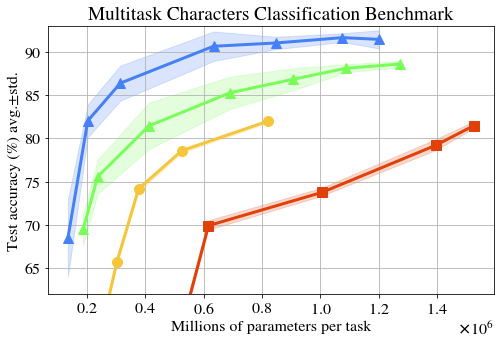

In [ ]:
# @title Run
title = 'Multitask Characters Classification Benchmark'
x_range = None
y_range = [62, 93]
plot_pqsa(exps_data_pqsa,
          fig_size=20,
          x_range=x_range,
          y_range=y_range,
          colors =[
                   '#4680f6',  # blue
                   '#79fe59',  # green
                   '#f5c53a',  # oragne
                   '#e14109',  # red
          ],
          markers=['^', '^', 'o', 's'],
          add_legend=False,
          x_exp=6,
          )

## Summary table

In [ ]:
# @title Library
def get_row(row_name, exps_data, exp_name, size_index):
  get_quality = get_test_quality
  yfn = lambda df: 100*get_quality(df)

  xsd = {}
  ysd = {}
  esd = {}
  tsd = {} # tpu_hours
  num_points = None
  for rid in exps_data[exp_name]:
    xs = []
    ys = []
    es = []
    ts = []
    for e in exps_data[exp_name][rid]:
      es.append(e)
      xs.append(get_params_per_task(e.dfp))
      ys.append(yfn(e.dfp))
      ts.append(get_tpu_hours(e.dfh))
    xsd[rid], ysd[rid], esd[rid], tsd[rid] = zip(*sorted(zip(xs, ys, es, ts)))
    if not num_points:
      num_points = len(xsd[rid])
    assert num_points == len(xsd[rid]) == len(ysd[rid]), \
        f'{exp_name} {rid}'

  max_y, max_e = max([(ysd[k][size_index], esd[k][size_index]) for k in ysd])
  print(max_e.path)
  t = {}
  t['Model'] = row_name
  t['Max'] = f'{max_y:.2f}'
  t['Mean'] = f'{np.mean([ysd[k][size_index] for k in ysd]):.2f}'
  t['Std'] = f'$\\pm${np.std([ysd[k][size_index] for k in ysd]):.2f}'
  t['Parameters per task'] = f'{int(np.mean([xsd[k][size_index] for k in xsd])):,}'
  t['TPU hours'] = f"{np.mean([tsd[k][size_index] for k in tsd]):.2f}"
  return  pd.DataFrame(t, index=[0])

def format_table(df, caption=None):
  ls = st = t.to_latex(escape=False, index=False)
  ls = ls.replace('muNet', '$\mu$Net')

  ls = ls.replace('llllll', '|l|ccc|r|c|')
  ls = ls.replace('toprule', 'toprule\n & \\multicolumn{3}{|c|}{Test Acc. \%} & Parameters & \\\\')
  ls = ls.replace('Parameters per task', '\\multicolumn{1}{|c|}{per task}')
  ls = '\\begin{center}\n' + ls + '\\end{center}\n'
  ls = '\\label{table:label}\n' + ls
  ls = ls + f'\\caption{{{caption}}}\n'
  ls = '\\begin{table*}[tbh]\n' + ls + '\\end{table*}\n'
  return ls

In [ ]:
# @title Load data
t = pd.DataFrame()

# Reusing data from the "Plot quality/size aggegated" section.
exps_data = exps_data_pqsa

row_name = 'Multihead'
exp_name = 'Fine-tune top layers'
size_index = 0
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

row_name = 'Full finetuning'
exp_name = 'Fine-tune top layers'
size_index = -1
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

row_name = 'Residual adapters dim=512'
exp_name = 'Residual adapters'
size_index = -1
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

row_name = 'muNet w/o auto-tuning'
exp_name = 'muNet w/o auto-tuning'
size_index = -1
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

row_name = 'muNet scale=0.3'
exp_name = 'muNet'
size_index = 1
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

row_name = 'muNet'
exp_name = 'muNet'
size_index = -1
row = get_row(row_name, exps_data, exp_name, size_index)
t = t.append(row)

In [ ]:
# @title Run
caption = 'TODO CAPTION'
print(format_table(t, caption))

## Indivitual tasks learning curves

In [ ]:
# @title Library
def get_task_evals(ed, task_name):
  row = ed.dfp.query(f'task_name=="{task_name}"')
  if task_name == NOT_TRAINABLE or len(row) == 0:
    return []
  assert len(row) == 1, f'{task_name} {len(row)}'
  test_eval = row['metrics.test_quality'].to_list()[0]
  evals = []
  ancestor_id = row['id'].to_list()[0]
  ancestor_task_name = task_name
  while ancestor_task_name != NOT_TRAINABLE:
    row = ed.dfh.query(f'id=={ancestor_id}')
    assert len(row) == 1
    if ancestor_task_name == task_name:
      all_evals = list(json.loads(row['metrics.evals'].to_list()[0]))
      best_eval_idx = all_evals.index(max(all_evals))
      if row['parent_task_name'].to_list()[0] == NOT_TRAINABLE and len(evals) == 0:
        # baseline
        evals = all_evals
      else:
        evals = all_evals[:best_eval_idx+1] + evals
      assert len(evals) > 0
    ancestor_id = row['parent_id'].to_list()[0]
    ancestor_task_name = row['parent_task_name'].to_list()[0]
  return list(zip(range(len(evals)), evals)), test_eval

def map_exp_data(exps_data, fn):
  rtn ={}
  for k in exps_data:
    rtn[k] = [fn(ed) for ed in exps_data[k]]
  return rtn

def plot_grid(plots_data, ncols=5, figsize=(20, 20),
              colors=None, save_dir=''):
  plt.rcParams["font.family"] = "STIXGeneral"
  plt.rcParams["font.size"] = 16

  if not colors:
    colors = [
              '#4680f6',  # blue
              '#e14109',  # red
              '#79fe59',  # green
              '#f5c53a',  # oragne
    ]
  colors_map = defaultdict(lambda:colors.pop(0))
  keys = list(plots_data.keys())

  nrows = int(np.ceil(len(keys) / ncols))
  fig, ax = plt.subplots(
      nrows=nrows,
      ncols=ncols,
      figsize=figsize,
      dpi=500)
  for i, row in enumerate(ax):
    for j, col in enumerate(row):
      k_idx = i * ncols + j
      if k_idx >= len(keys):
        continue
      k = keys[k_idx]
      title = k
      title = title.replace('visual_domain_decathlon/', '')
      col.set_title(title)
      maxy = 0
      miny = np.inf
      for exp_k in plots_data[k].keys():
        color = colors_map[exp_k]
        for h, vs in enumerate(plots_data[k][exp_k]):
          if not vs:
            continue
          test_eval = vs[1]
          vs = vs[0]
          xs, ys = zip(*vs)
          label = exp_k if i==j==h==0 else None
          col.plot(xs, ys, label=label, color=color, alpha=0.4, linewidth=1.5)
          if max(list(xs)) == xlim_itlc-1:
            # baseline
            selected = max(vs, key=lambda x: x[1])
          else:
            # muNet
            selected = vs[-1]
          col.plot(*selected, color=color, marker='+',markersize=8, markeredgewidth=1.5)
          col.plot(selected[0], test_eval, color=color, marker='o', markerfacecolor='none', markersize=8, markeredgewidth=1.5)
          col.plot([selected[0], selected[0]], [selected[1], test_eval], linestyle=':', color=color, linewidth=1, alpha=1)
          xs, ys = zip(*vs)
          maxy = max(list(ys) + [maxy, test_eval])
          miny = min([np.mean(ys), miny])
      col.set_ylim([miny*0.95, maxy * 1.007])
      col.set_xlim([0, xlim_itlc])
  fig.legend(ncol=2,
             bbox_to_anchor=(0.613, 0.91),
             )
  plt.subplots_adjust(
       hspace=0.23, wspace=0.09)
  if save_dir:
    plt.savefig('/tmp/crvs.pdf', dpi=500, bbox_inches='tight')
    output_file = save_dir + '/crvs.pdf'
    tf.io.gfile.copy('/tmp/crvs.pdf', output_file, overwrite=True)
    print('Saved to:', output_file)

  plt.show()

In [ ]:
# @title Load data
exps_data_itlc = {}
exps_data_itlc['muNet'] = get_exps_data('TODO_EXPS_DIRS_REGEXP')
exps_data_itlc['Full fine-tune'] = get_exps_data('TODO_EXPS_DIRS_REGEXP')
xlim_itlc = 480  # Max number of validations (i.e. validations for basline models)

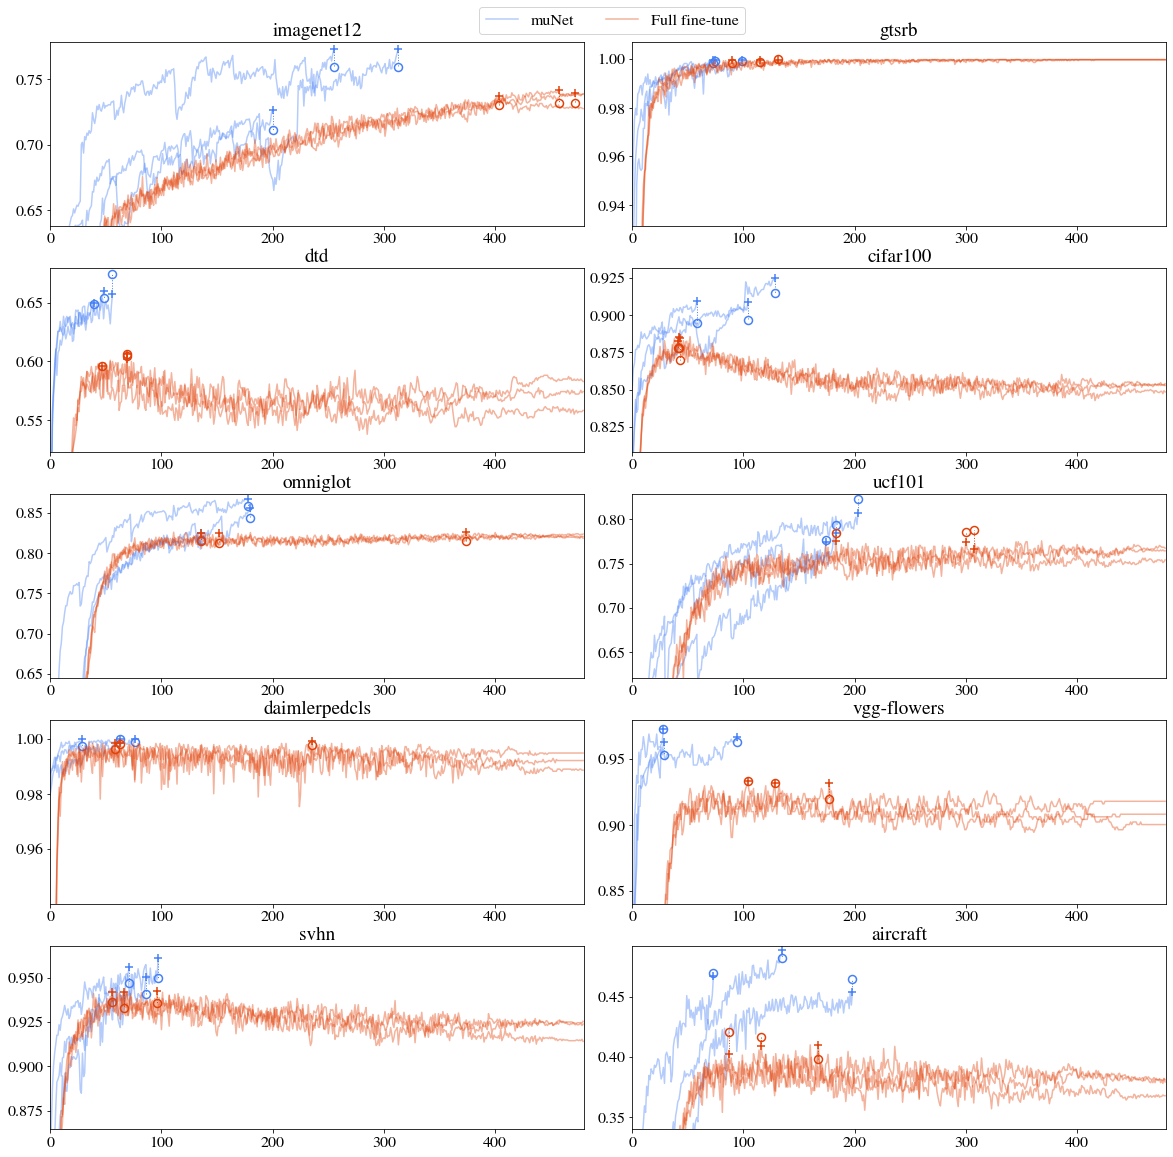

In [ ]:
# @title Run
task_names = set()
for k in exps_data_itlc:
  task_names = task_names.union(exps_data_itlc[k][0].dfp.query('task_name!="NOT_TRAINABLE"').task_name.to_list())

plots_data = {}
for tn in task_names:
  plots_data[tn] = map_exp_data(
      exps_data_itlc,
      partial(get_task_evals, task_name=tn))

plot_grid(plots_data, ncols=2)